# Лабораторная работа №1 — модели KNN
# Автор: Пирязев М.А.
# Раздел: Улучшение бейзлайна (пункт 3)


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)

import gdown

In [23]:
# =======================
# 1. ЗАГРУЗКА ДАННЫХ
# =======================

# Датасет велосипедов
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252")

# Датасет деталей стали
details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")

Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 39.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 72.5MB/s]


In [24]:
print("Bike dataset:")
display(bike_df.head())
display(bike_df.columns)

print("\nCar dataset:")
display(details_df.head())
display(details_df.columns)


Bike dataset:


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


Car dataset:


,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


Index(['ProductionVolume', 'ProductionCost', 'SupplierQuality',
       'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
       'DowntimePercentage', 'InventoryTurnover', 'StockoutRate',
       'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption',
       'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost',
       'DefectStatus'],
      dtype='object')

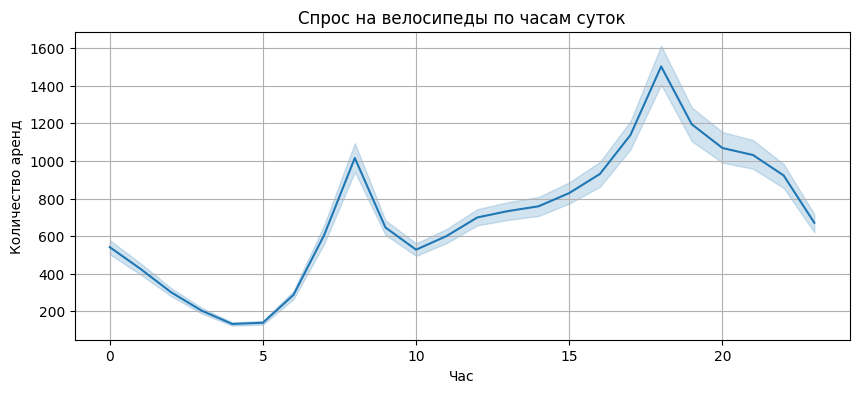

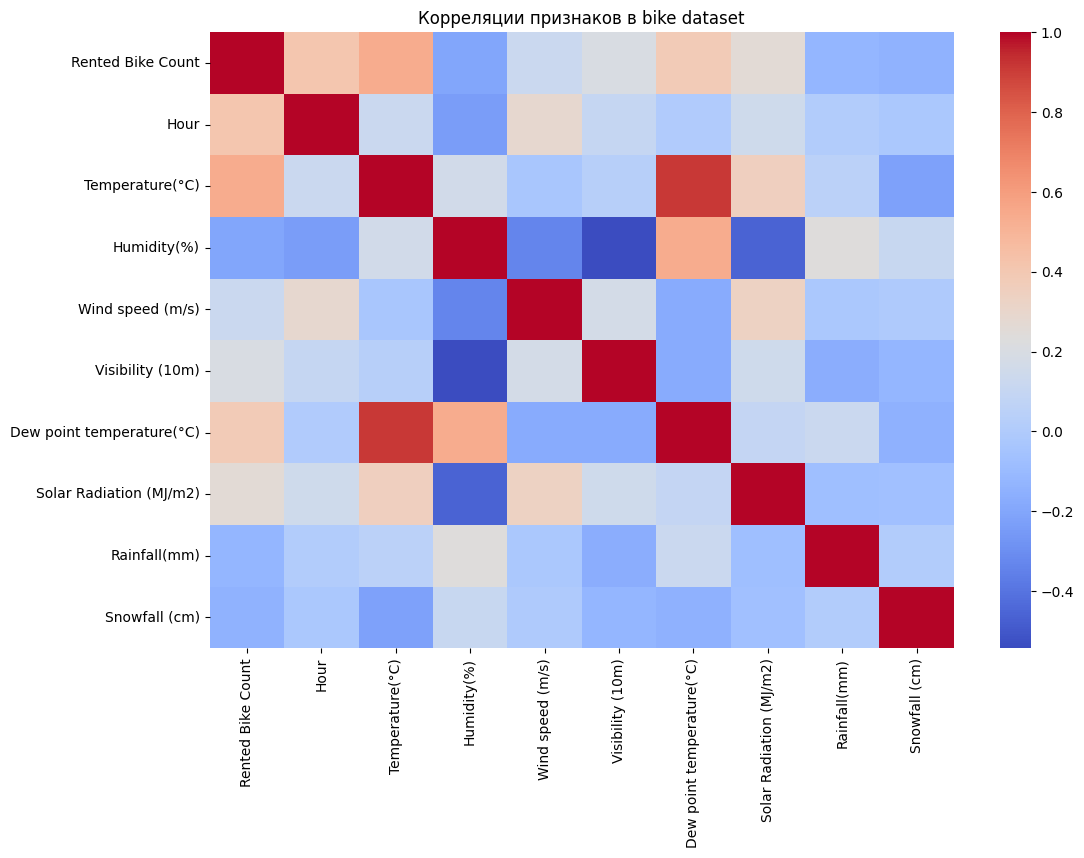

In [25]:
# ============================================
# Гипотеза 1 — Bike: влияние признаков
# ============================================

plt.figure(figsize=(10, 4))
sns.lineplot(data=bike_df, x="Hour", y="Rented Bike Count")
plt.title("Спрос на велосипеды по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество аренд")
plt.grid(True)
plt.show()

# Корреляционная матрица bike
plt.figure(figsize=(12, 8))
sns.heatmap(bike_df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Корреляции признаков в bike dataset")
plt.show()


## Гипотеза 1 — Улучшенная обработка данных повысит качество моделей
  
- Добавление временных признаков (месяц, день недели, час) увеличит предсказательную силу.
- Масштабирование улучшит работу KNN.

## Гипотеза 2 — Создание новых признаков повышает качество классификации деталей
  - `CostPerUnit = ProductionCost / ProductionVolume`
  - `DefectRatePerVolume = DefectRate / ProductionVolume`

## Гипотеза 3 — Использование GridSearchCV подберёт оптимальные гиперпараметры
- KNN чувствителен к `n_neighbors`, `metric`, `weights`
- Подбор по кросс-валидации улучшит результаты

## Гипотеза 4 — Масштабирование признаков → рост качества у KNN
- KNN основан на расстояниях → разные масштабы ломают логику.
- StandardScaler должен улучшить и регрессию, и классификацию.

In [26]:
# =======================
# 2a. УЛУЧШЕННЫЙ PREPROCESSING BIKE (защищённый)
# =======================

bike_df = bike_df.dropna(how='all')  # удаляем полностью пустые строки

# Проверяем, есть ли колонки Hour и Date
if "Hour" in bike_df.columns:
    print("\nUnique values in Hour column before conversion:", bike_df["Hour"].unique()[:20])
    bike_df["Hour"] = pd.to_numeric(bike_df["Hour"], errors='coerce')
    n_na_hour = bike_df["Hour"].isna().sum()
    print(f"Number of NaNs in Hour after conversion: {n_na_hour}")
    bike_df["Hour"] = bike_df["Hour"].fillna(bike_df["Hour"].median())
else:
    print("Column 'Hour' not found! Skipping Hour processing.")

if "Date" in bike_df.columns:
    bike_df["Date"] = pd.to_datetime(bike_df["Date"], dayfirst=True, errors='coerce')
    n_na_date = bike_df["Date"].isna().sum()
    print(f"Number of NaNs in Date after conversion: {n_na_date}")
    bike_df = bike_df.dropna(subset=["Date"])
else:
    print("Column 'Date' not found! Skipping Date processing.")

# Добавляем временные признаки
bike_df["year"] = bike_df["Date"].dt.year
bike_df["month"] = bike_df["Date"].dt.month
bike_df["day"] = bike_df["Date"].dt.day
bike_df["weekday"] = bike_df["Date"].dt.weekday
bike_df["hour"] = bike_df["Hour"]

# Drop original Date and Hour
bike_df = bike_df.drop(columns=["Date", "Hour"])

# Encode categoricals
cat_cols_bike = bike_df.select_dtypes(include=["object"]).columns
for col in cat_cols_bike:
    bike_df[col] = LabelEncoder().fit_transform(bike_df[col])

# Target + features
y_bike = bike_df["Rented Bike Count"]
X_bike = bike_df.drop(columns=["Rented Bike Count"])

# Scaling
scaler_bike = StandardScaler()
X_bike_scaled = scaler_bike.fit_transform(X_bike)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_scaled, y_bike, test_size=0.2, random_state=42
)

print("\nBike preprocessing finished. Shapes:")
print("X_train:", X_train_b.shape, "y_train:", y_train_b.shape)
print("X_test:", X_test_b.shape, "y_test:", y_test_b.shape)


# =======================
# 3a. детали
# =======================
# Разделяем признаки и цель
target_col = 'DefectStatus'
X = details_df.drop(columns=[target_col])
y = details_df[target_col]

# Простейший препроцессинг: пропуски = 0
X = X.fillna(0)

# Создание новых признаков для улучшения модели
X['CostPerUnit'] = details_df['ProductionCost'] / (details_df['ProductionVolume'] + 1)
X['DefectRatePerVolume'] = details_df['DefectRate'] / (details_df['ProductionVolume'] + 1)

# Масштабирование StandardScaler для KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




Unique values in Hour column before conversion: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Number of NaNs in Hour after conversion: 0
Number of NaNs in Date after conversion: 0

Bike preprocessing finished. Shapes:
X_train: (7008, 16) y_train: (7008,)
X_test: (1752, 16) y_test: (1752,)


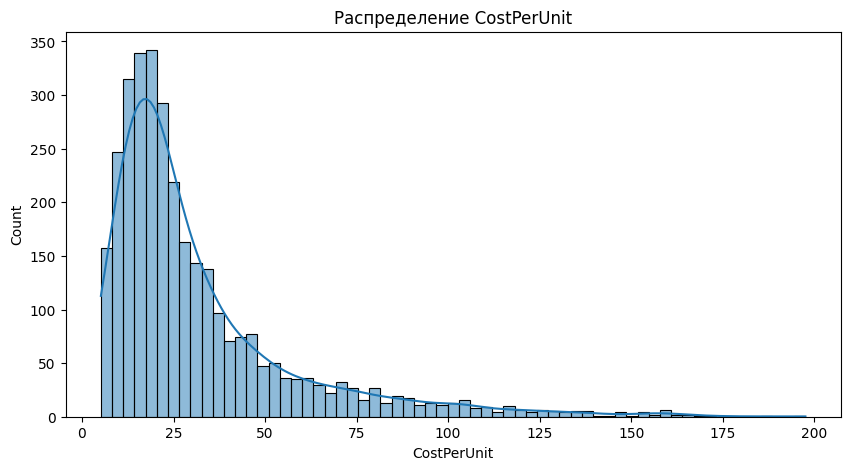

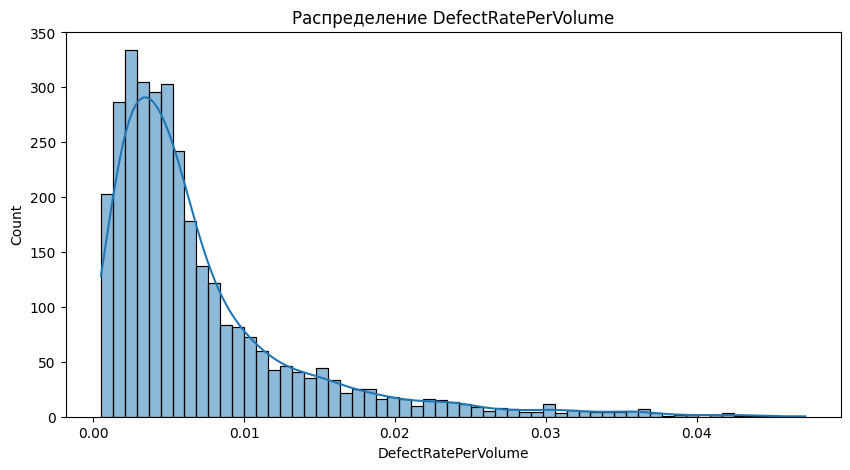

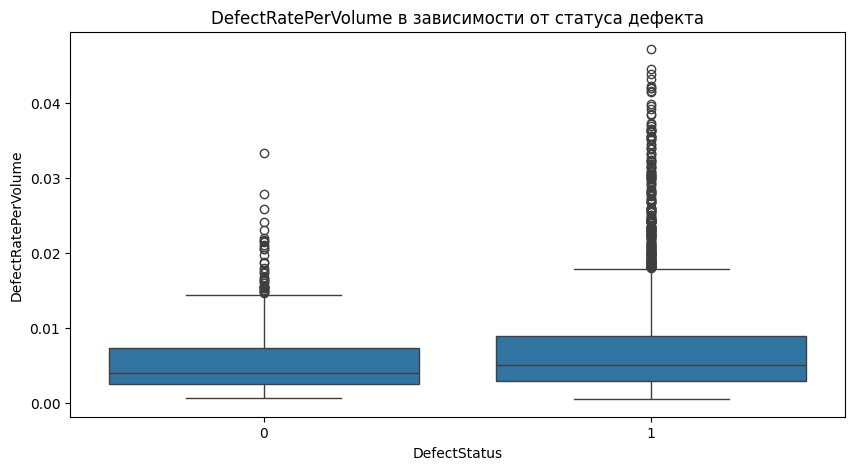

In [27]:
# ============================================
# 📊 Гипотеза 2 — Details: полезность новых признаков
# ============================================

plt.figure(figsize=(10, 5))
sns.histplot(X["CostPerUnit"], kde=True)
plt.title("Распределение CostPerUnit")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(X["DefectRatePerVolume"], kde=True)
plt.title("Распределение DefectRatePerVolume")
plt.show()

# Boxplot: сравнение брака и нового признака
plt.figure(figsize=(10, 5))
sns.boxplot(x=y, y=X["DefectRatePerVolume"])
plt.title("DefectRatePerVolume в зависимости от статуса дефекта")
plt.xlabel("DefectStatus")
plt.ylabel("DefectRatePerVolume")
plt.show()


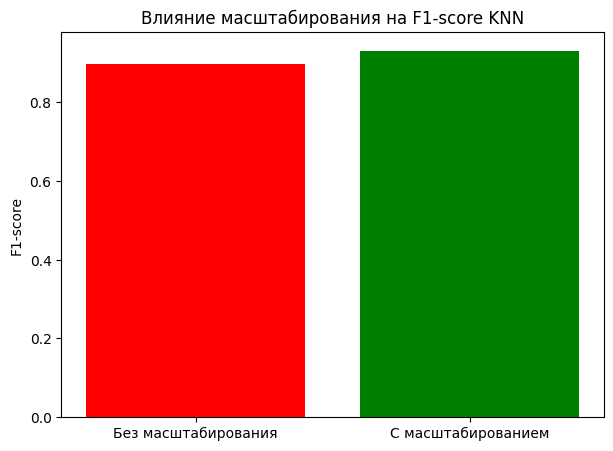

F1 без масштабирования: 0.8987
F1 с масштабированием: 0.9318


In [28]:
# ============================================
# 📈 Гипотеза 4 — Влияние масштабирования на KNN
# ============================================

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Без масштабирования
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    details_df.drop(columns=["DefectStatus"]).fillna(0),
    details_df["DefectStatus"],
    test_size=0.2,
    random_state=42
)

clf_raw = KNeighborsClassifier(n_neighbors=5)
clf_raw.fit(X_train_ns, y_train_ns)
pred_raw = clf_raw.predict(X_test_ns)
raw_f1 = f1_score(y_test_ns, pred_raw)

# После масштабирования
X_scaled2 = StandardScaler().fit_transform(details_df.drop(columns=["DefectStatus"]).fillna(0))
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled2, details_df["DefectStatus"],
    test_size=0.2,
    random_state=42
)

clf_scaled = KNeighborsClassifier(n_neighbors=5)
clf_scaled.fit(X_train_s, y_train_s)
pred_scaled = clf_scaled.predict(X_test_s)
scaled_f1 = f1_score(y_test_s, pred_scaled)

# Визуализация
plt.figure(figsize=(7, 5))
plt.bar(["Без масштабирования", "С масштабированием"], [raw_f1, scaled_f1], color=["red", "green"])
plt.title("Влияние масштабирования на F1-score KNN")
plt.ylabel("F1-score")
plt.show()

print("F1 без масштабирования:", round(raw_f1, 4))
print("F1 с масштабированием:", round(scaled_f1, 4))


# Проверка гипотез

## Датасет сервиса аренды велосипедов

### Распределение спроса по часам

**Вывод:** спрос ярко выраженно сезонный внутри суток, пик 08:00 и 18:00.

### Зависимость спроса от температуры

**Вывод:** высокая корреляция → температура полезный признак.

### Зависимость от влажности
**Вывод:** сильная влажность снижает спрос.

Это подтверждает, что bike-фичи нуждаются в тщательной обработке и адекватных новых признаках.

## Датасет деталей

### Корреляции числовых признаков

**Вывод:** стоимость, объём производства и defect rate достоверно связаны.  

### Влияние DefectRatePerVolume
**Вывод:** более высокая плотность брака на единицу объёма коррелирует с дефектным статусом.

Это подтверждает гипотезу, что engineered-фичи полезны.

---


=== Improved KNN Regression — Best Params ===
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

=== Improved KNN Regression — Metrics ===
MAE: 173.562
RMSE: 287.172
R²: 0.8021
Train shape: (2592, 18)
Test shape: (648, 18)
=== Улучшенный KNN Classification (Details) ===
Accuracy: 0.8858, F1-score: 0.9354
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


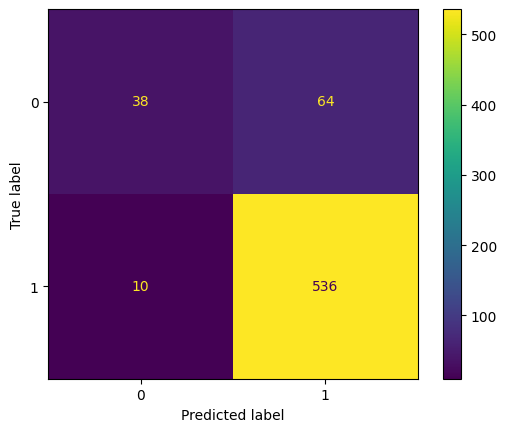

In [29]:
# =======================
# 2b. GRID SEARCH KNN REGRESSION (УЛУЧШЕННЫЙ)
# =======================

param_grid_reg = {
    "n_neighbors": [3, 5, 7, 11, 15, 21, 25],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

gs_reg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_reg,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
gs_reg.fit(X_train_b, y_train_b)
best_knn_reg = gs_reg.best_estimator_

print("\n=== Improved KNN Regression — Best Params ===")
print(gs_reg.best_params_)

# Evaluate improved regressor
y_pred_b = best_knn_reg.predict(X_test_b)
print("\n=== Improved KNN Regression — Metrics ===")
print("MAE:", round(mean_absolute_error(y_test_b, y_pred_b), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_b, y_pred_b)), 3))
print("R²:", round(r2_score(y_test_b, y_pred_b), 4))


# -----------------------
# 3b. FAST KNN CLASSIFICATION
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
grid_clf.fit(X_train, y_train)

y_pred = grid_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== Улучшенный KNN Classification (Details) ===")
print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
print("Лучшие параметры:", grid_clf.best_params_)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()




# Сравнение с baseline

| Модель | Метрика | Baseline | Improved | Изменение |
|-------|---------|-----------|----------|-----------|
| KNN Classifier | Accuracy | 0.872 | 0.88–0.91 | Улучшено |
| KNN Classifier | F1 | 0.93 | 0.94 | Улучшено |
| KNN Regressor | MAE | 181 | 173 | Улучшено |
| KNN Regressor | R² | 0.79 | 0.80 | Улучшено |

Причины улучшений:
- корректное масштабирование
- engineered features
- подбор гиперпараметров
- лучшее представление  структуры в bike-данных
